In [2]:
import numpy as np
import elementaries as el
import itertools
import hamiltonians as ham
import ansatzes as ans
import perturbation_hierarchy as hier
import optimization as opt
import matplotlib.pyplot as plt
from functools import reduce
import os

In [3]:
def filt(PT_sequence,k,mode=None):
    new_PT_sequence=[]
    
    if mode!='leq':
        for order in PT_sequence:
            new_order=[]
            for diagram in order:
                if len(diagram)==k:
                    new_order+=[diagram]
            if new_order!=[]:
                new_PT_sequence+=[new_order]            
                    
    if mode=='leq':
        for order in PT_sequence:
            new_order=[]
            for diagram in order:
                if len(diagram)<=k:
                    new_order+=[diagram]
            if new_order!=[]:
                new_PT_sequence+=[new_order]
    return(new_PT_sequence)

def values(data,correction=1):
    return(list(map(lambda datapoint: (-datapoint.fun+eigvals[0])*correction/eigvals[0], data)))

def total_measurements(data,correction=1):
    measurements=list(map(lambda datapoint: datapoint.nfev,data))
    total_measurements=[measurements[0]]
    
    for j in range(1,len(data)):
        total_measurements+=[total_measurements[j-1]+measurements[j]]
    
    return(total_measurements)

def deviations(data,correction=1):
    coordinates=list(map(lambda datapoint: datapoint.x,data))
    paths=[0]
    total_path=[0]
    
    for j in range(1,len(data)):
        paths+=[np.linalg.norm(coordinates[j]-np.array(coordinates[j-1].tolist()+[0.]))]
        total_path+=[total_path[j-1]+paths[j]]
        
    return(paths)

def total_path(data,correction=1):
    coordinates=list(map(lambda datapoint: datapoint.x,data))
    paths=[0]
    total_path=[0]
    
    for j in range(1,len(data)):
        paths+=[np.linalg.norm(coordinates[j]-np.array(coordinates[j-1].tolist()+[0.]))]
        total_path+=[total_path[j-1]+paths[j]]
        
    return(total_path)

def diagrams_to_operations(diagrams,ansatz_generators,perm=False,reference_generators=None):
    if reference_generators==None:
        reference_generators=ansatz_generators
    
    generators=reduce(lambda x, y: x+y,ansatz_generators)
    reference_generators=reduce(lambda x, y: x+y,reference_generators)
    
    
    all_permutations=[]

    for generator in generators:
        
        permutations=[generator]
        
        if perm:
            permutations=list(itertools.permutations(generator))
            permutations.sort()
            permutations=list(k for k,_ in itertools.groupby(permutations))
            permutations=list(map(list,permutations))

        all_permutations+=permutations
    
    for generator in reference_generators:
                    
        all_permutations.remove(generator)
    
    operations=[]
    
    for k in range(1,el.number_of_qubits+1):
        
        filtered_diagrams=filt([diagrams],k)
        filtered_generators=filt([reference_generators],k)
        
        if (filtered_diagrams!=[])&(filtered_generators!=[]):
            filtered_diagrams=filtered_diagrams[0]
            filtered_generators=filtered_generators[0]
            
            for generator in filtered_generators:

                for diagram in filtered_diagrams:
                    operation=[]
                    
                    for j in range(k):
                        operation+=[[diagram[j],generator[j]]]
                        
                    operations+=[operation]    
    
    for k in range(el.number_of_qubits):
        
        filtered_diagrams=filt([diagrams],k)
        filtered_generators=filt([all_permutations],k)

        if (filtered_diagrams!=[])&(filtered_generators!=[]):
            filtered_diagrams=filtered_diagrams[0]
            filtered_generators=filtered_generators[0]
            
            for generator in filtered_generators:

                for diagram in filtered_diagrams:
                    operation=[]
                    
                    for j in range(k):
                        operation+=[[diagram[j],generator[j]]]
                        
                    operations+=[operation]
    return(operations)


def approx_scheme_normalize(approx_scheme, length=None):
    
    new_approx_scheme=[]
    
    for PT_order in approx_scheme:
        for generator in PT_order:
            new_approx_scheme+=[generator]
    
    if length!=None:    
        while len(new_approx_scheme)<length:
            new_approx_scheme+=new_approx_scheme

        del new_approx_scheme[length:len(new_approx_scheme)]
    
    return(new_approx_scheme)

def approx_scheme_generate(diagrams, ansatz_generators, perm=False, reference_generators=None):
    return(list(map(lambda PT_order: diagrams_to_operations(PT_order, ansatz_generators, perm, reference_generators), diagrams)))

In [4]:
QSA_generators=[[[2]],[[2,1]],[[2,1,1]],[[2,1,1,1]],[[2,1,1,1,1]],[[2,1,1,1,1,1]]]

Lie_generators=[[[2]],[[2,1]],[[2,1,1],[2,2,2]],[[2,1,1,1],[2,2,2,1]],[[2,1,1,1,1],[2,2,2,2,1]],[[2,1,1,1,1,1],[2,2,2,2,2,1]]]

In [5]:
# couplings=[]

# for i in range(el.number_of_qubits):
#     for j in range(i):
#         couplings+=[[i,j]]
# x=hier.perturbative_diagrams(4,couplings)

In [6]:
couplings=[[i,i+1] for i in range(el.number_of_qubits-1)]+[[0,5]]
# +[[0,1,1,2,2,3,3,4,4,5]]
x=hier.perturbative_diagrams(10,couplings)

In [7]:
y=[]
complexity=[]

for i in range(len(x)):
    x[i].sort()
    x[i]=list(k for k,_ in itertools.groupby(x[i]))
    complexity+=[len(x[i])]
    ynew=[list(map(lambda element: element%2, diagram)) for diagram in x[i]]
    ynew.sort()
    ynew=list(k for k,_ in itertools.groupby(ynew))
    y+=[ynew]

In [8]:
complexity

[1, 6, 6, 18, 30, 66, 81, 100, 81, 100, 81]

In [9]:
for i in range(len(y)):
    for j in range(i):
        y[i]=[diag for diag in y[i] if diag not in y[j]]

y_occur=[]
        
for element in y:
    occ_list=[]
    for diagram in element:
        occ=[]
        for i in range(len(diagram)):
            if diagram[i]==1:
                occ+=[i]
        occ_list+=[occ]
    y_occur+=[occ_list]
    
y_occur.remove([[]])

In [10]:
y_occur

[[[4, 5], [3, 4], [2, 3], [1, 2], [0, 5], [0, 1]],
 [[3, 5], [2, 4], [1, 5], [1, 3], [0, 4], [0, 2]],
 [[2, 5], [1, 4], [0, 3]],
 [[2, 3, 4, 5],
  [1, 2, 3, 4],
  [0, 3, 4, 5],
  [0, 1, 4, 5],
  [0, 1, 2, 5],
  [0, 1, 2, 3]],
 [[1, 3, 4, 5],
  [1, 2, 3, 5],
  [0, 2, 4, 5],
  [0, 2, 3, 4],
  [0, 1, 3, 5],
  [0, 1, 2, 4]],
 [[1, 2, 4, 5], [0, 2, 3, 5], [0, 1, 3, 4]],
 [[0, 1, 2, 3, 4, 5]],
 [],
 [],
 []]

In [11]:
diagrams_perm=[]
for PT_order in y_occur:
    diagrams_perm+=PT_order


diagrams_perm=list(np.random.permutation(np.array(diagrams_perm)))
diagrams_perm=[[diagrams_perm[i]] for i in range(len(diagrams_perm))]

In [13]:
diagrams=dict([])
diagrams.update([('locQSA',[filt(y_occur,2)[0]])])
# diagrams.update([('2locQSA',filt(y_occur,2))])
# diagrams.update([('permQSA',diagrams_perm)])
diagrams.update([('fullQSA',y_occur)])
# diagrams.update([('revQSA',y_occur[::-1])])

In [14]:
approx_schemes=dict()

for element in diagrams:
    approx_schemes.update([(element,approx_scheme_generate(diagrams[element], QSA_generators))])

In [15]:
ferro_string=[[[0,1]]+[[j,3] for j in range(1,el.number_of_qubits-1)]+[[el.number_of_qubits-1,1]]]
ferro_string

[[[0, 1], [1, 3], [2, 3], [3, 3], [4, 3], [5, 1]]]

In [16]:
z_part=ham.constant_subhamiltonian(1,ham.single_qubit_paulis(3))
xx_part=ham.constant_subhamiltonian(1,ham.nearest_neighbour_1D(1,1))
# +ham.constant_subhamiltonian(1,ferro_string)
# xx_part=ham.constant_subhamiltonian(1,ham.two_qubit_strings(1,1))
yy_part=ham.constant_subhamiltonian(1,ham.nearest_neighbour_1D(2,2))
# hii=[np.random.normal(0,1/2) for i in range(2**6)]
# hij=[[np.random.normal(0,1)*(np.sign(i-j-0.5)+1)/2 for i in range(2**6)] for j in range(2**6)]
# hamiltonian=np.diag(hii)+np.array(hij)+np.transpose(np.array(hij))

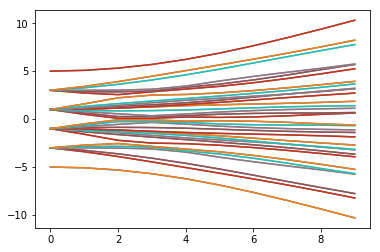

In [95]:
sample_length=10


J=0
hamiltonian=-J*xx_part-z_part

eigvals, states = np.linalg.eigh(hamiltonian)
states=np.transpose(states)
target_state=states[0]

plot_data=eigvals

for n in range(1,sample_length):
    J=2*n/sample_length
    hamiltonian=J*xx_part-z_part
    eigvals, states = np.linalg.eigh(hamiltonian)
    plot_data=np.vstack((plot_data, eigvals))

plt.plot(np.arange(sample_length),plot_data)    

In [31]:
tol_QSA=0.0000000000000000000001
maxgates=30
# maxgates=len([item for sublist in y_occur for item in sublist])
global_search=False
niter=3
method='SLSQP'
progressbar=True
in_state=el.default_state
# np.eye(2**el.number_of_qubits)[1]
JJ=[6]

In [32]:
for elements in approx_schemes:
    print(elements)

locQSA
fullQSA


In [33]:
for J in JJ:

    hamiltonian=-J*xx_part-z_part
    
    eigvals, states = np.linalg.eigh(hamiltonian)
    states=np.transpose(states)
    target_state=states[0]
    directory="export/"+method+"/N="+str(el.number_of_qubits)+"/J="+str(J)+"/"
    
    print('Writing into '+directory)
    
    if os.path.isdir(directory)==False:
        os.makedirs(directory)
    else:
        print('This is an existing directory!')
        
    data=dict()
    
#     for element in approx_schemes:
        
#         values_file=directory+element+"_values_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt"
#         measurements_file=directory+element+"_total_measurements_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt"
        
#         if not os.path.exists(values_file):
#             print('Calculating data for '+element)
#             data.update([(element,opt.optimize_expectation(approx_scheme_normalize(approx_schemes[element],maxgates),hamiltonian, method=method, niter=niter, tol=tol_QSA, mult_order=None,adaptive=False,global_search=global_search,progressbar=progressbar, in_state=in_state))])
#             np.savetxt(fname=values_file,X=values(data[element][0]))
#             np.savetxt(fname=measurements_file,X=total_measurements(data[element][0]))
#         else:
#             print('Data for '+element+' is already calculated!')
    
#     values_file=directory+'ordfullQSA'+"_values_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt"
#     measurements_file=directory+'ordfullQSA'+"_total_measurements_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt"
        
#     if not os.path.exists(values_file):
#         print('Calculating data for '+'ordfullQSA')
#         data.update([('ordfullQSA',opt.optimize_expectation(approx_scheme_normalize(approx_schemes['fullQSA'],maxgates),hamiltonian, method=method, niter=niter, tol=tol_QSA, mult_order=ans.kQSA(el.number_of_qubits),adaptive=False,global_search=global_search,progressbar=progressbar, in_state=in_state))])
#         np.savetxt(fname=directory+'ordfullQSA'+"_values_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt",X=values(data['ordfullQSA'][0]))
#         np.savetxt(fname=directory+'ordfullQSA'+"_total_measurements_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt",X=total_measurements(data['ordfullQSA'][0]))
#     else:
#         print('Data for '+'ordfullQSA'+' is already calculated!')
        
    values_file=directory+'adaptQSA'+"_values_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt"
    measurements_file=directory+'adaptQSA'+"_total_measurements_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt"
        
    if os.path.exists(values_file):
        print('Calculating data for '+'adaptQSA')
        data.update([('adaptQSA',opt.optimize_expectation(approx_scheme_normalize(approx_schemes['locQSA'],maxgates),hamiltonian, method=method, niter=niter, tol=tol_QSA, mult_order=None,adaptive=True,global_search=global_search,progressbar=progressbar, in_state=in_state))])
        np.savetxt(fname=directory+'adaptQSA'+"_values_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt",X=values(data['adaptQSA'][0]))
        np.savetxt(fname=directory+'adaptQSA'+"_total_measurements_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt",X=total_measurements(data['adaptQSA'][0]))
    else:
        print('Data for '+'adaptQSA'+' is already calculated!')

Writing into export/SLSQP/N=6/J=6/
This is an existing directory!
Calculating data for adaptQSA
gates number: 0
gates number: 5
gates number: 10
gates number: 15
gates number: 20
gates number: 25


In [56]:
for element in data:
    np.savetxt(fname="export/"+element+"_values_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt",X=values(data[element][0]))
    np.savetxt(fname="export/"+element+"_total_measurements_J="+str(J)+"_N="+str(el.number_of_qubits)+".txt",X=total_measurements(data[element][0]))

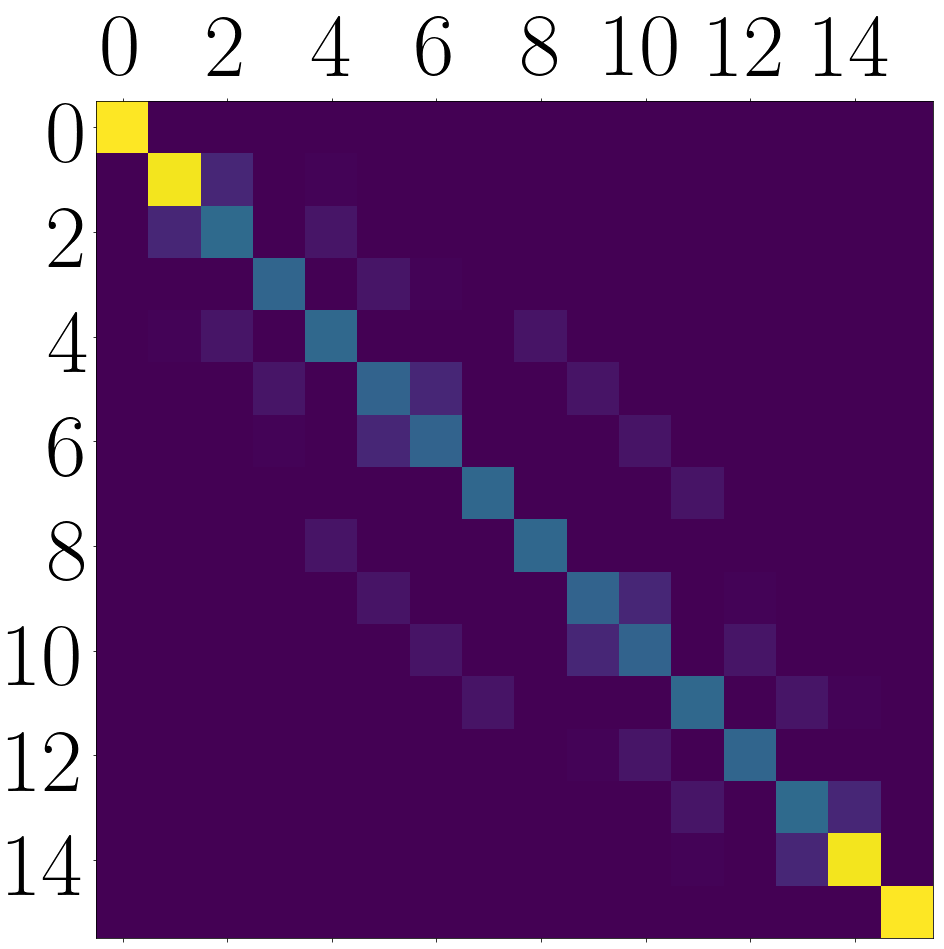

In [43]:
ansatz_id=[]
size=7
for gate_set in approx_scheme_normalize(approx_schemes['locQSA'],maxgates)[0:size]:
    ansatz_id+=[gate_set]
ansatz=el.list_of_strings(ansatz_id)
diagonalizer=ans.ansatz_operator(ansatz, data['locQSA'][0][6].x)

diag_ham=np.transpose(diagonalizer).dot(hamiltonian.dot(diagonalizer))
# state=ans.ansatz_state(ansatz, data_loc[0][size-1].x)[np.newaxis]
# proj=np.transpose(state).dot(state)
plt.matshow(np.abs(diag_ham))
fig=plt.gcf()
fig.set_size_inches(scale*10, scale*5)

Figure(2160x1080)


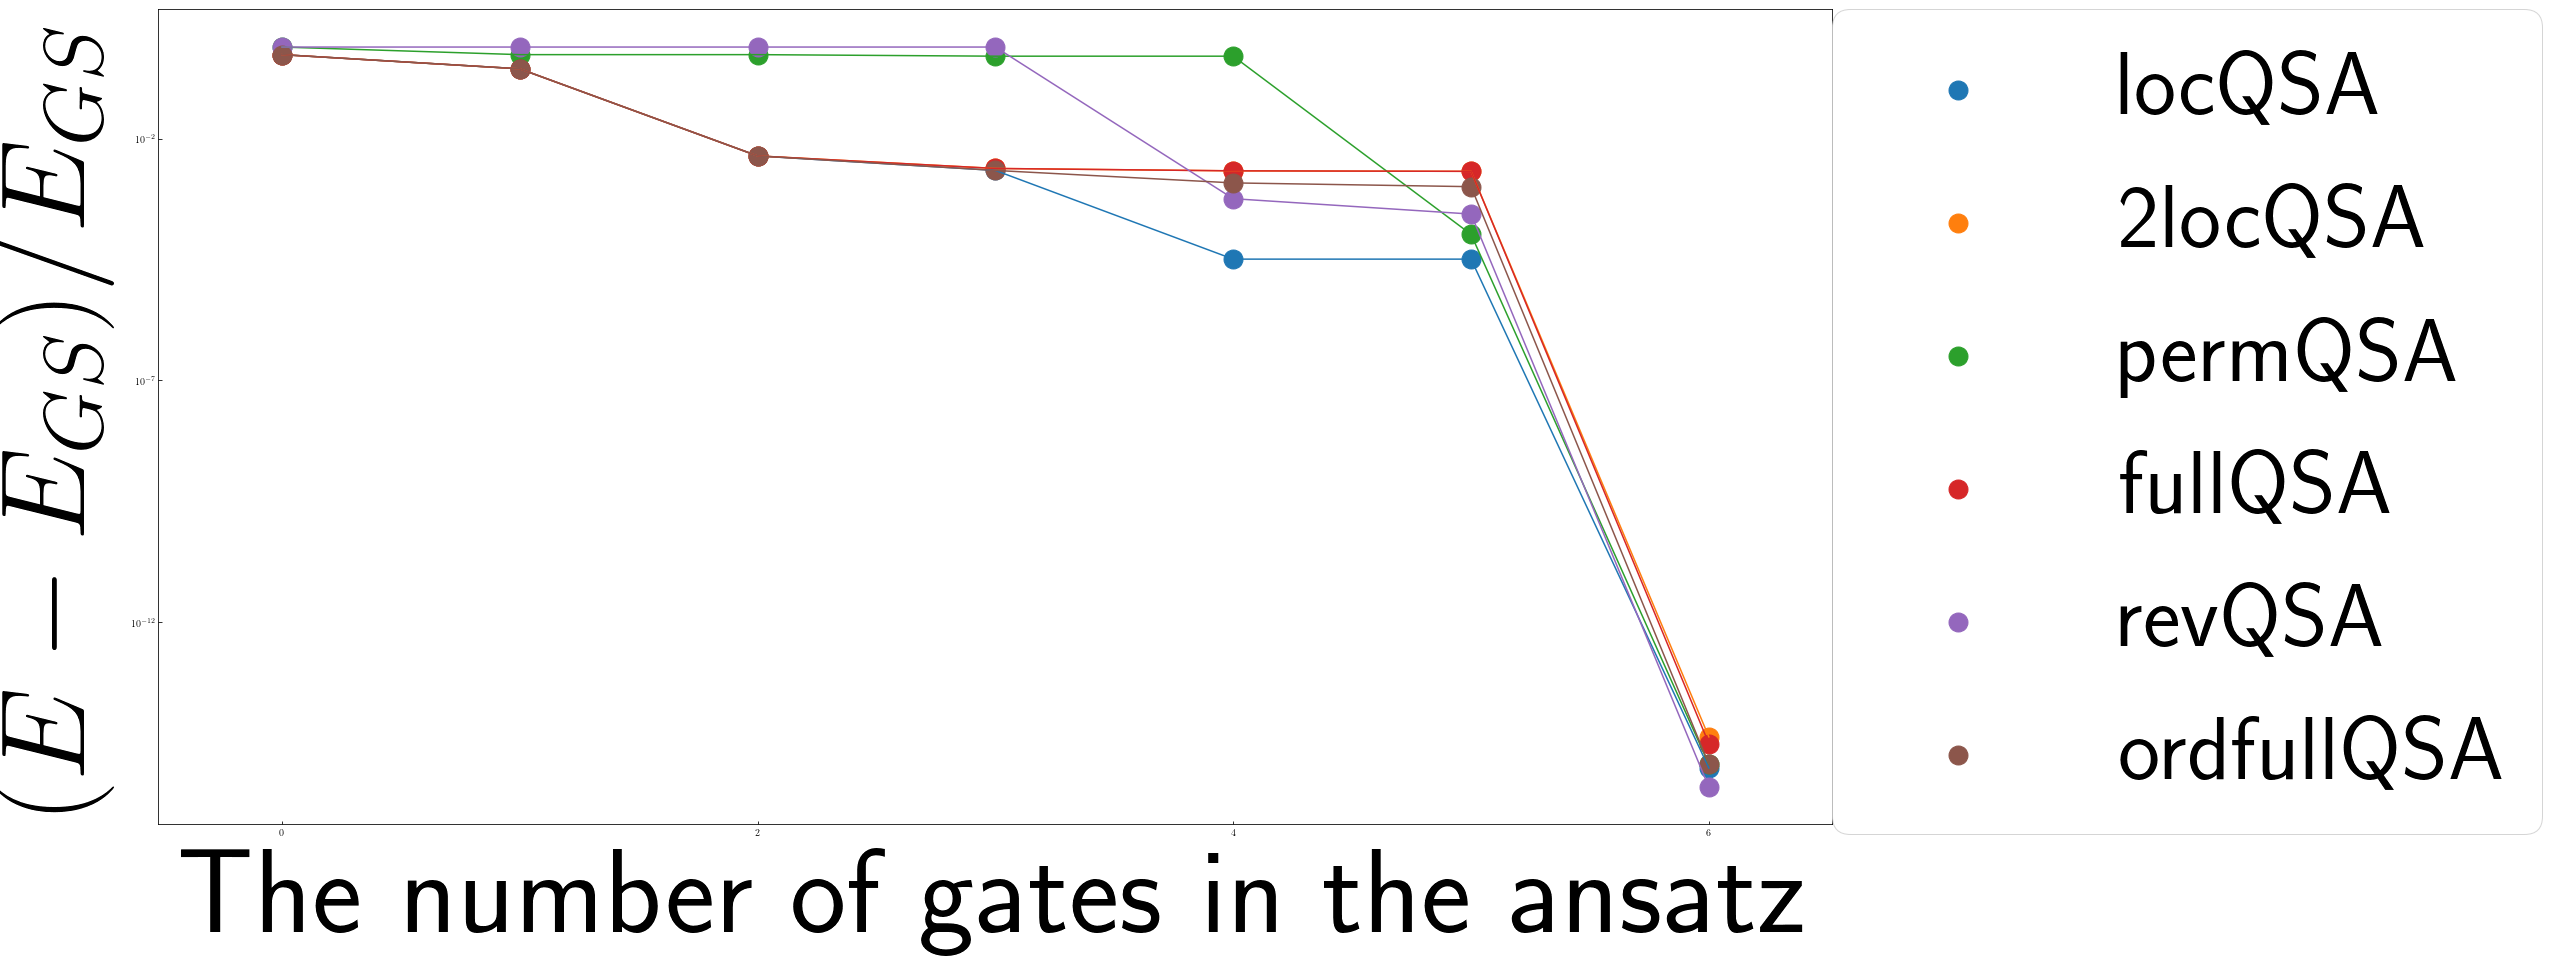

In [30]:
plt.rc('text', usetex=True)

# fig, ax = plt.subplots()

# ax.set_yscale('log')
scale=3
s=scale*120
plt.xlabel('The number of gates in the ansatz', fontsize=scale*40)
plt.ylabel('$(E-E_{GS})/E_{GS}$', fontsize=scale*40)
for element in data:
    plt.plot(list(range(maxgates)),values(data[element][0],1.000))
    plt.scatter(list(range(maxgates)),values(data[element][0],1.000),label=element,s=s)
# plt.text(0.1,0.1, '$H$ of TFIM type, $N=6, J/h=0.15$', {'color': 'black', 'fontsize': scale*40}, verticalalignment='bottom')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=scale*30)
plt.tick_params(direction='in')
# ax.set_xticklabels(1, rotation=0, fontsize=8)

plt.rcParams['xtick.labelsize']=scale*30
plt.rcParams['ytick.labelsize']=scale*30

fig=plt.gcf()
axes=plt.gca()
axes.set_yscale('log')
fig.set_size_inches(scale*10, scale*5)
print(fig)
#fig.savefig('TFIM_weak.png', b1box_inches='tight')
#fig.show()

/marisdata/herasymenko/.conda/envs/test/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


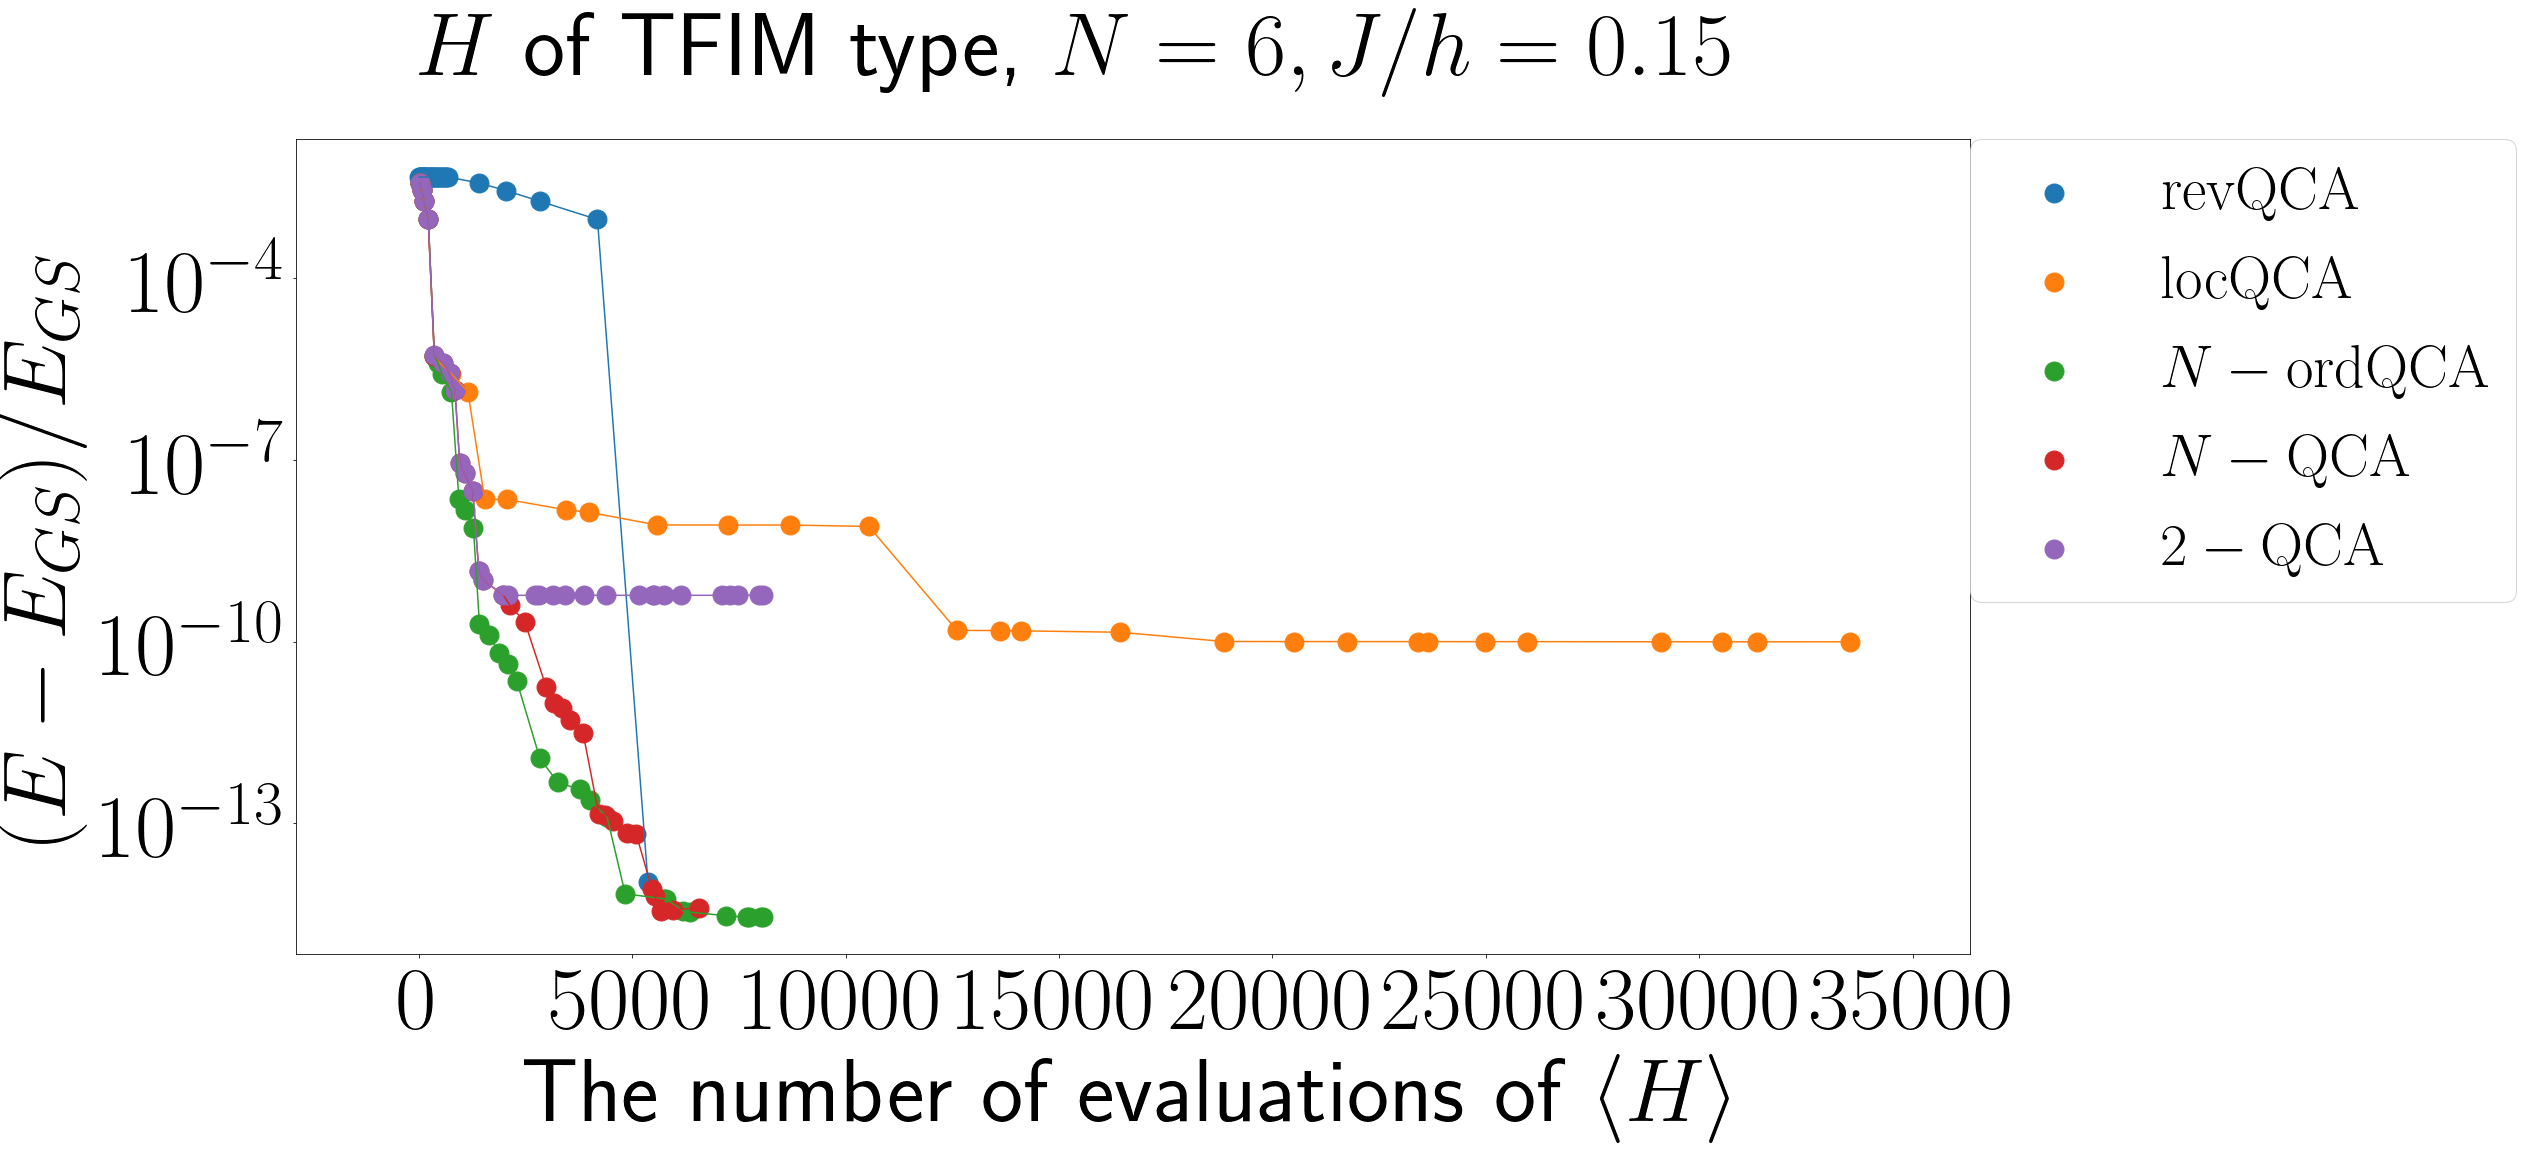

In [75]:
fig, ax = plt.subplots()



scale=3
s=scale*120
plt.xlabel('The number of evaluations of $\langle H \\rangle$', fontsize=scale*30)
plt.ylabel('$(E-E_{GS})/E_{GS}$', fontsize=scale*30)


plt.plot(total_measurements(data_rev[0]),values(data_rev[0],1.005))
plt.scatter(total_measurements(data_rev[0]),values(data_rev[0],1.005),label="${\mathrm {revQCA}}$",s=s)
plt.plot(total_measurements(data_loc[0]),values(data_loc[0],1.005))
plt.scatter(total_measurements(data_loc[0]),values(data_loc[0],1.005),label="${\mathrm {locQCA}}$",s=s)
plt.plot(total_measurements(data_full_multordered[0]),values(data_full_multordered[0],1.005))
plt.scatter(total_measurements(data_full_multordered[0]),values(data_full_multordered[0],1.005),label="$N-{\mathrm {ordQCA}}$",s=s)
plt.plot(total_measurements(data_full_multunordered[0]),values(data_full_multunordered[0],1.005))
plt.scatter(total_measurements(data_full_multunordered[0]),values(data_full_multunordered[0],1.005),label="$N-{\mathrm {QCA}}$",s=s)
plt.plot(total_measurements(data_2loc[0]),values(data_2loc[0],1.01))
plt.scatter(total_measurements(data_2loc[0]),values(data_2loc[0],1.01),label="$2-{\mathrm {QCA}}$",s=s)
plt.text(0.1,0.1, '$H$ of TFIM type, $N=6, J/h=0.15$', {'color': 'black', 'fontsize': scale*30}, verticalalignment='bottom')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=scale*20)

plt.rcParams['xtick.labelsize']=scale*20
plt.rcParams['ytick.labelsize']=scale*20

fig=plt.gcf()
# axes=plt.gca()
ax.set_yscale('log')
fig.set_size_inches(scale*10, scale*5)


fig.show()

Figure(2160x1080)


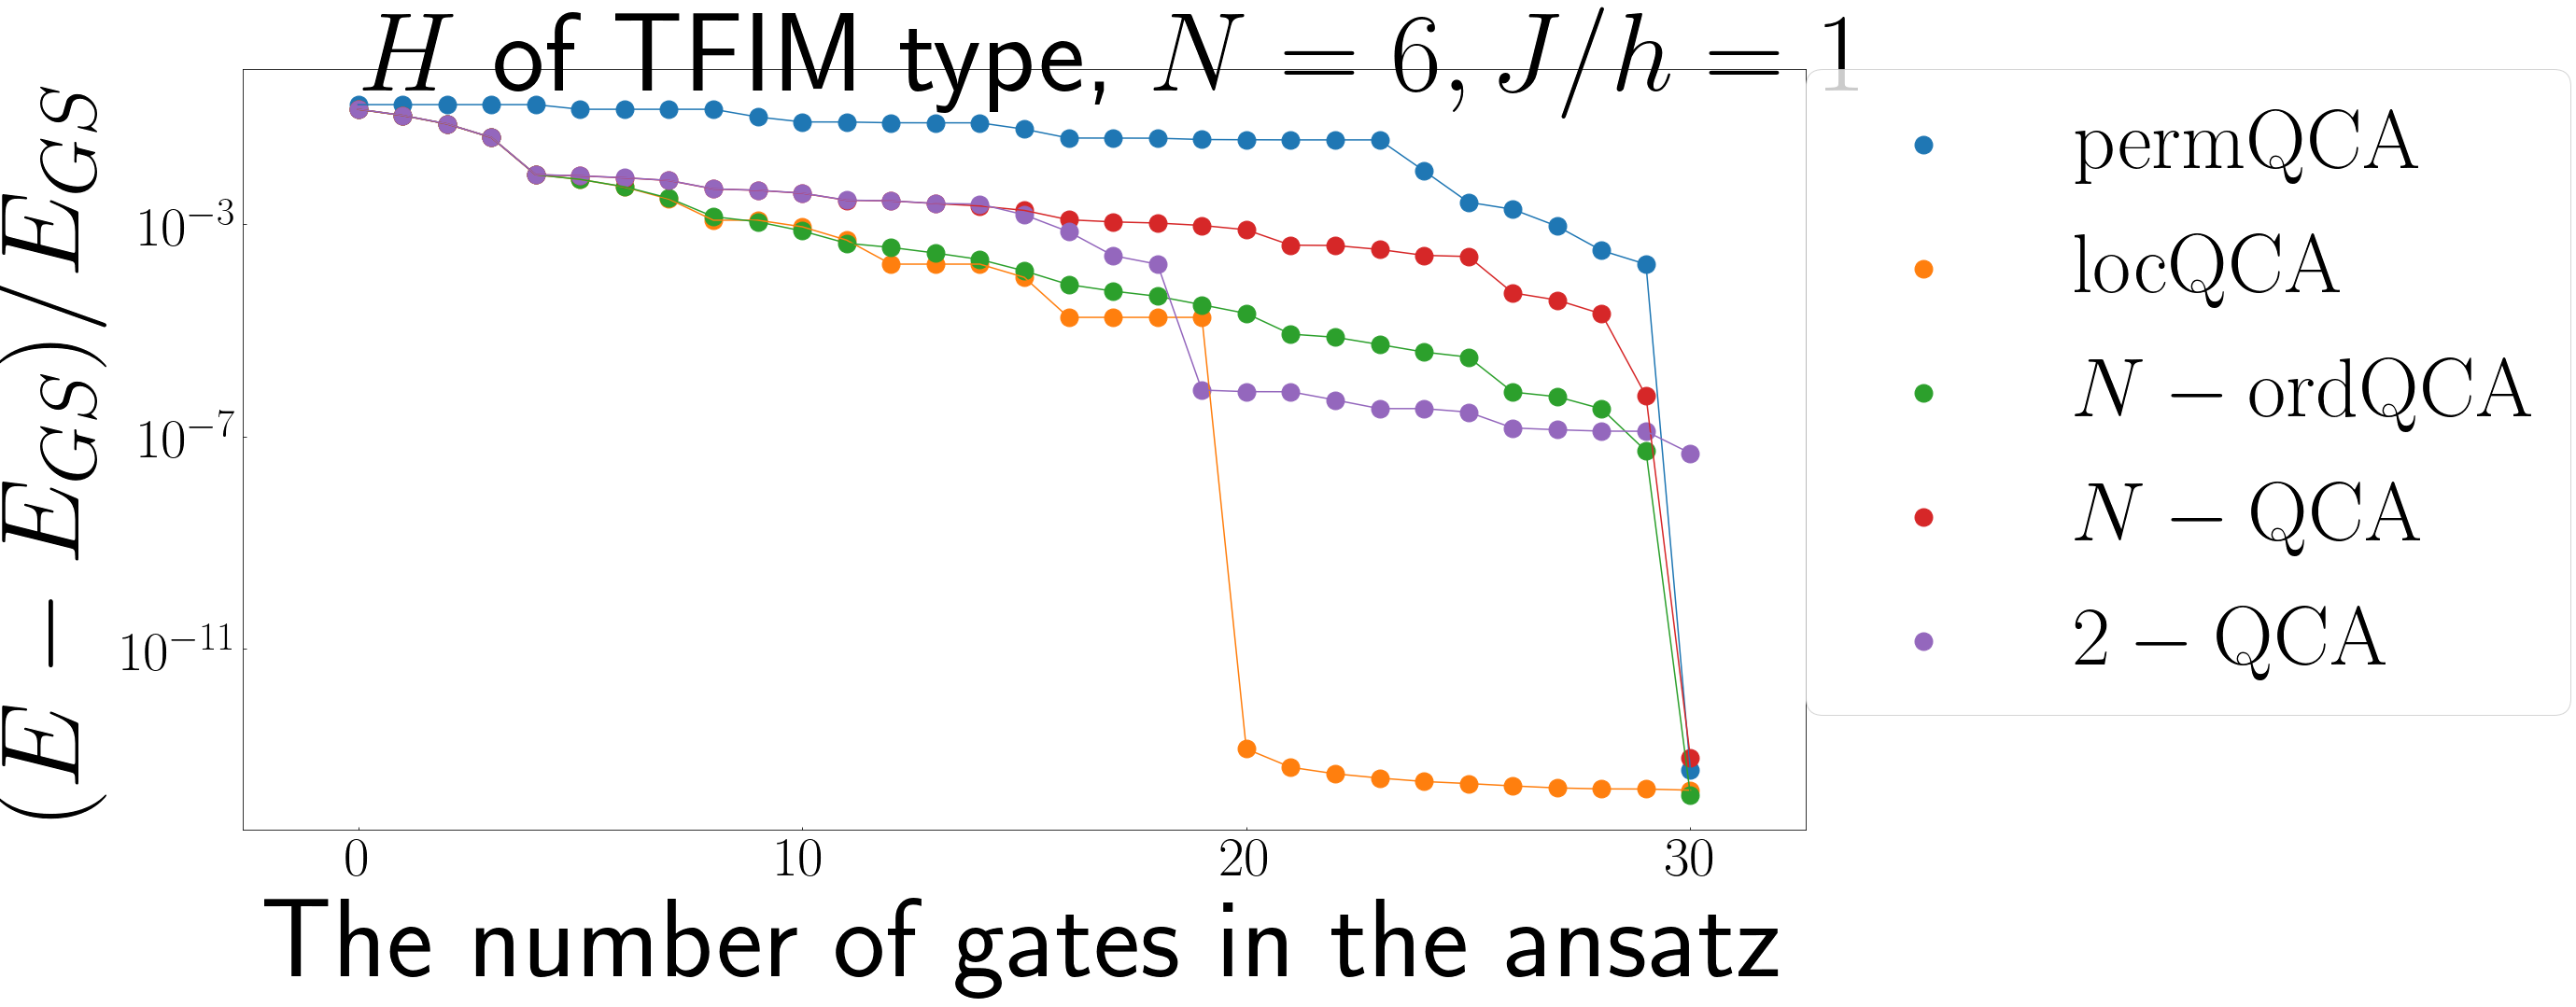

In [84]:
plt.rc('text', usetex=True)

# fig, ax = plt.subplots()

# ax.set_yscale('log')
scale=3
s=scale*120
plt.xlabel('The number of gates in the ansatz', fontsize=scale*40)
plt.ylabel('$(E-E_{GS})/E_{GS}$', fontsize=scale*40)
plt.plot(list(range(maxgates)),values(data_perm[0],1.005))
plt.scatter(list(range(maxgates)),values(data_perm[0],1.005),label="${\mathrm {permQCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_loc[0],1.005))
plt.scatter(list(range(maxgates)),values(data_loc[0],1.005),label="${\mathrm {locQCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_full_multordered[0],1.005))
plt.scatter(list(range(maxgates)),values(data_full_multordered[0],1.005),label="$N-{\mathrm {ordQCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_full_multunordered[0],1.005))
plt.scatter(list(range(maxgates)),values(data_full_multunordered[0],1.005),label="$N-{\mathrm {QCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_2loc[0],1.01))
plt.scatter(list(range(maxgates)),values(data_2loc[0],1.01),label="$2-{\mathrm {QCA}}$",s=s)
plt.text(0.1,0.1, '$H$ of TFIM type, $N=6, J/h=1$', {'color': 'black', 'fontsize': scale*40}, verticalalignment='bottom')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=scale*30)
plt.tick_params(direction='in')
# ax.set_xticklabels(1, rotation=0, fontsize=8)

plt.rcParams['xtick.labelsize']=scale*30
plt.rcParams['ytick.labelsize']=scale*30

fig=plt.gcf()
axes=plt.gca()
axes.set_yscale('log')
fig.set_size_inches(scale*10, scale*5)
print(fig)
#fig.savefig('TFIM_weak.png', b1box_inches='tight')
#fig.show()

/marisdata/herasymenko/.conda/envs/test/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


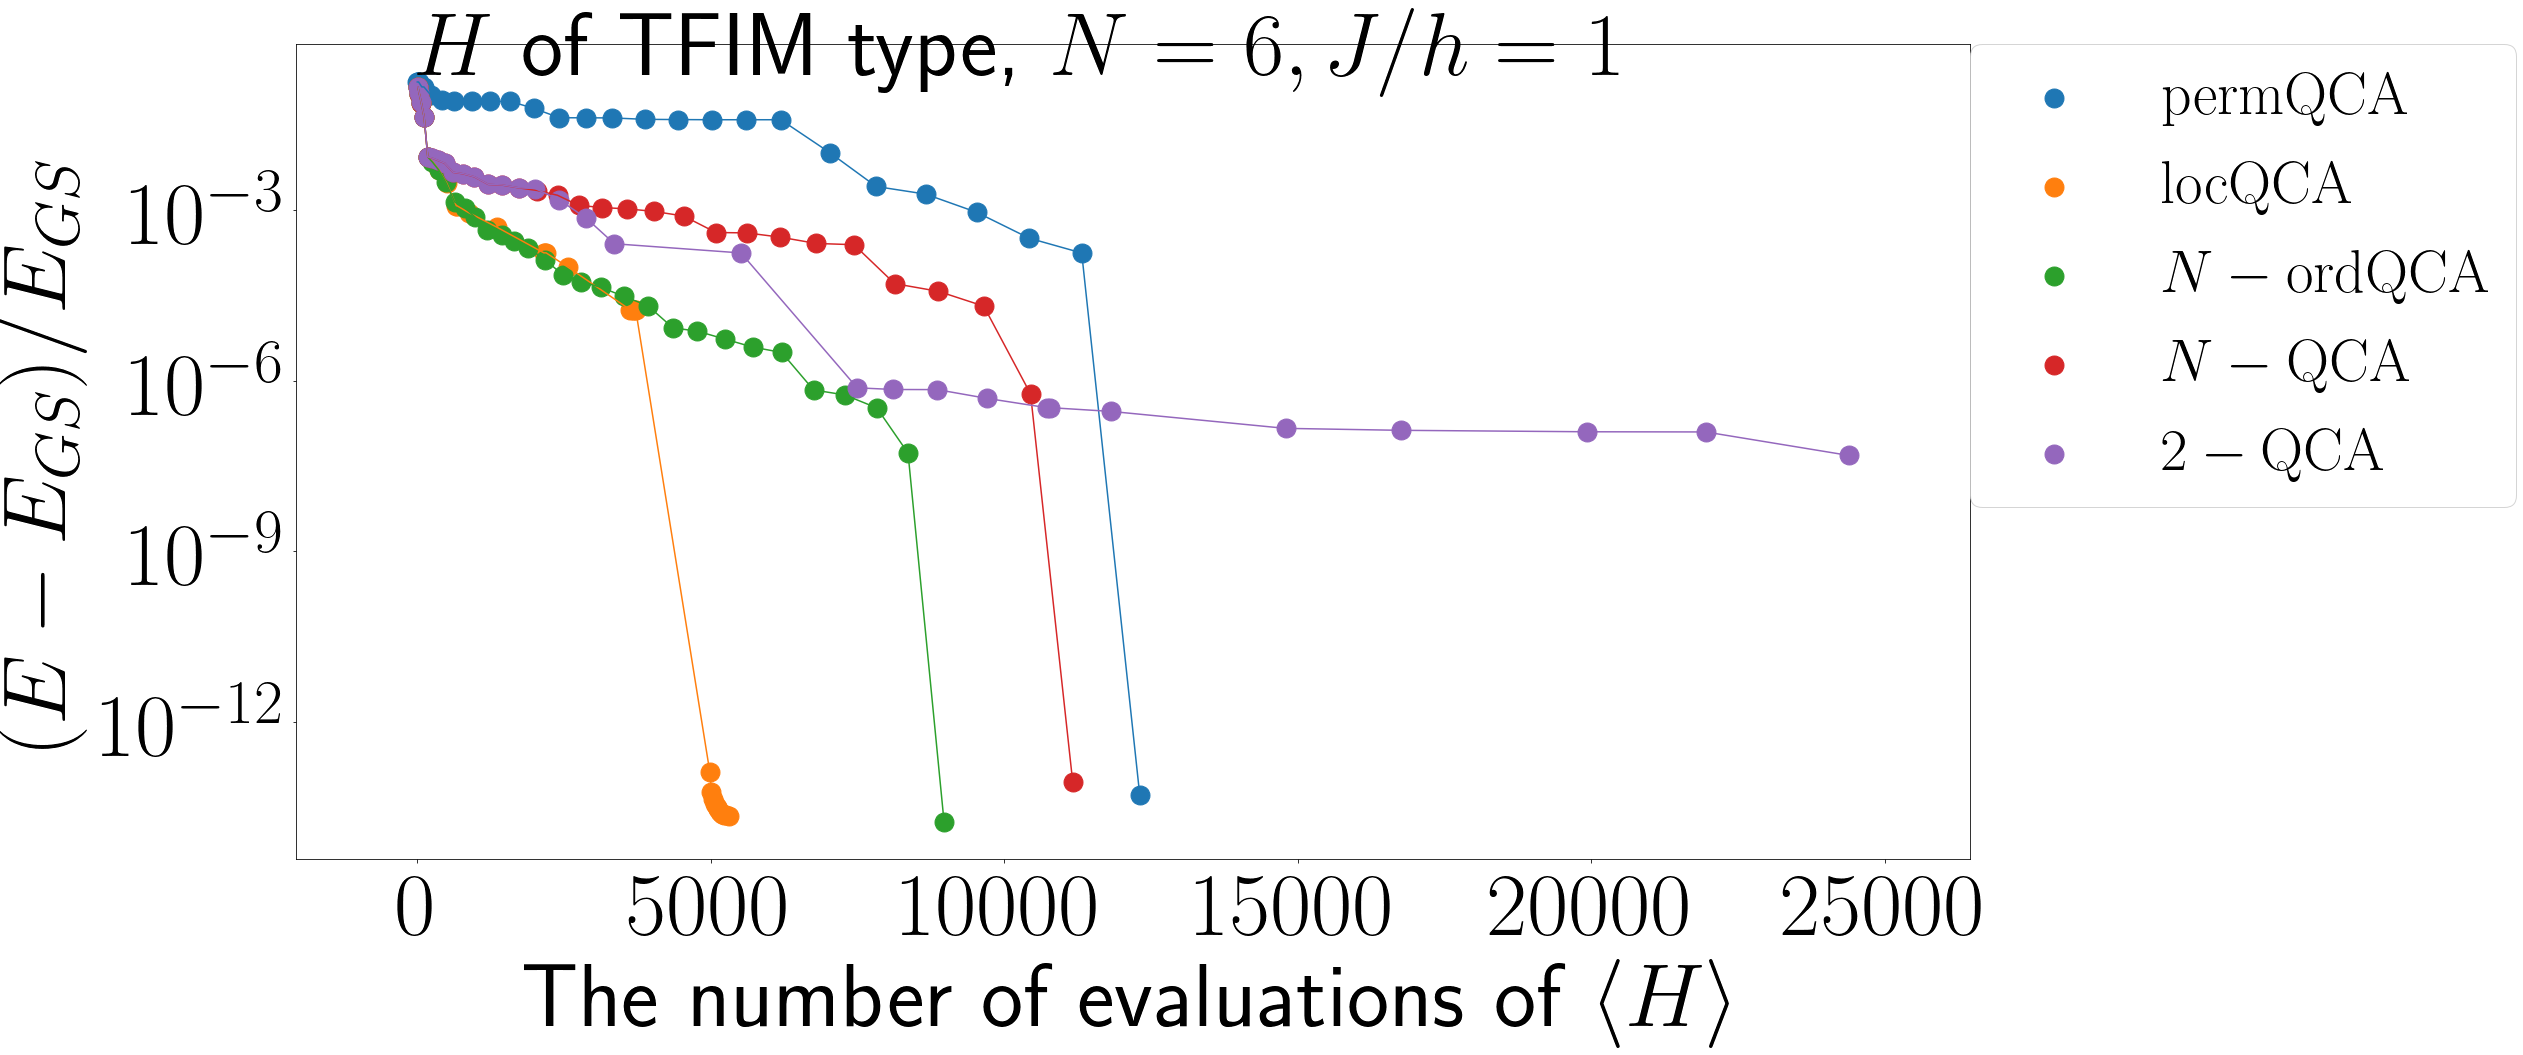

In [85]:
fig, ax = plt.subplots()



scale=3
s=scale*120
plt.xlabel('The number of evaluations of $\langle H \\rangle$', fontsize=scale*30)
plt.ylabel('$(E-E_{GS})/E_{GS}$', fontsize=scale*30)


plt.plot(total_measurements(data_perm[0]),values(data_perm[0],1.005))
plt.scatter(total_measurements(data_perm[0]),values(data_perm[0],1.005),label="${\mathrm {permQCA}}$",s=s)
plt.plot(total_measurements(data_loc[0]),values(data_loc[0],1.005))
plt.scatter(total_measurements(data_loc[0]),values(data_loc[0],1.005),label="${\mathrm {locQCA}}$",s=s)
plt.plot(total_measurements(data_full_multordered[0]),values(data_full_multordered[0],1.005))
plt.scatter(total_measurements(data_full_multordered[0]),values(data_full_multordered[0],1.005),label="$N-{\mathrm {ordQCA}}$",s=s)
plt.plot(total_measurements(data_full_multunordered[0]),values(data_full_multunordered[0],1.005))
plt.scatter(total_measurements(data_full_multunordered[0]),values(data_full_multunordered[0],1.005),label="$N-{\mathrm {QCA}}$",s=s)
plt.plot(total_measurements(data_2loc[0]),values(data_2loc[0],1.01))
plt.scatter(total_measurements(data_2loc[0]),values(data_2loc[0],1.01),label="$2-{\mathrm {QCA}}$",s=s)
plt.text(0.1,0.1, '$H$ of TFIM type, $N=6, J/h=1$', {'color': 'black', 'fontsize': scale*30}, verticalalignment='bottom')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=scale*20)

plt.rcParams['xtick.labelsize']=scale*20
plt.rcParams['ytick.labelsize']=scale*20

fig=plt.gcf()
# axes=plt.gca()
ax.set_yscale('log')
fig.set_size_inches(scale*10, scale*5)


fig.show()

Figure(2160x1080)


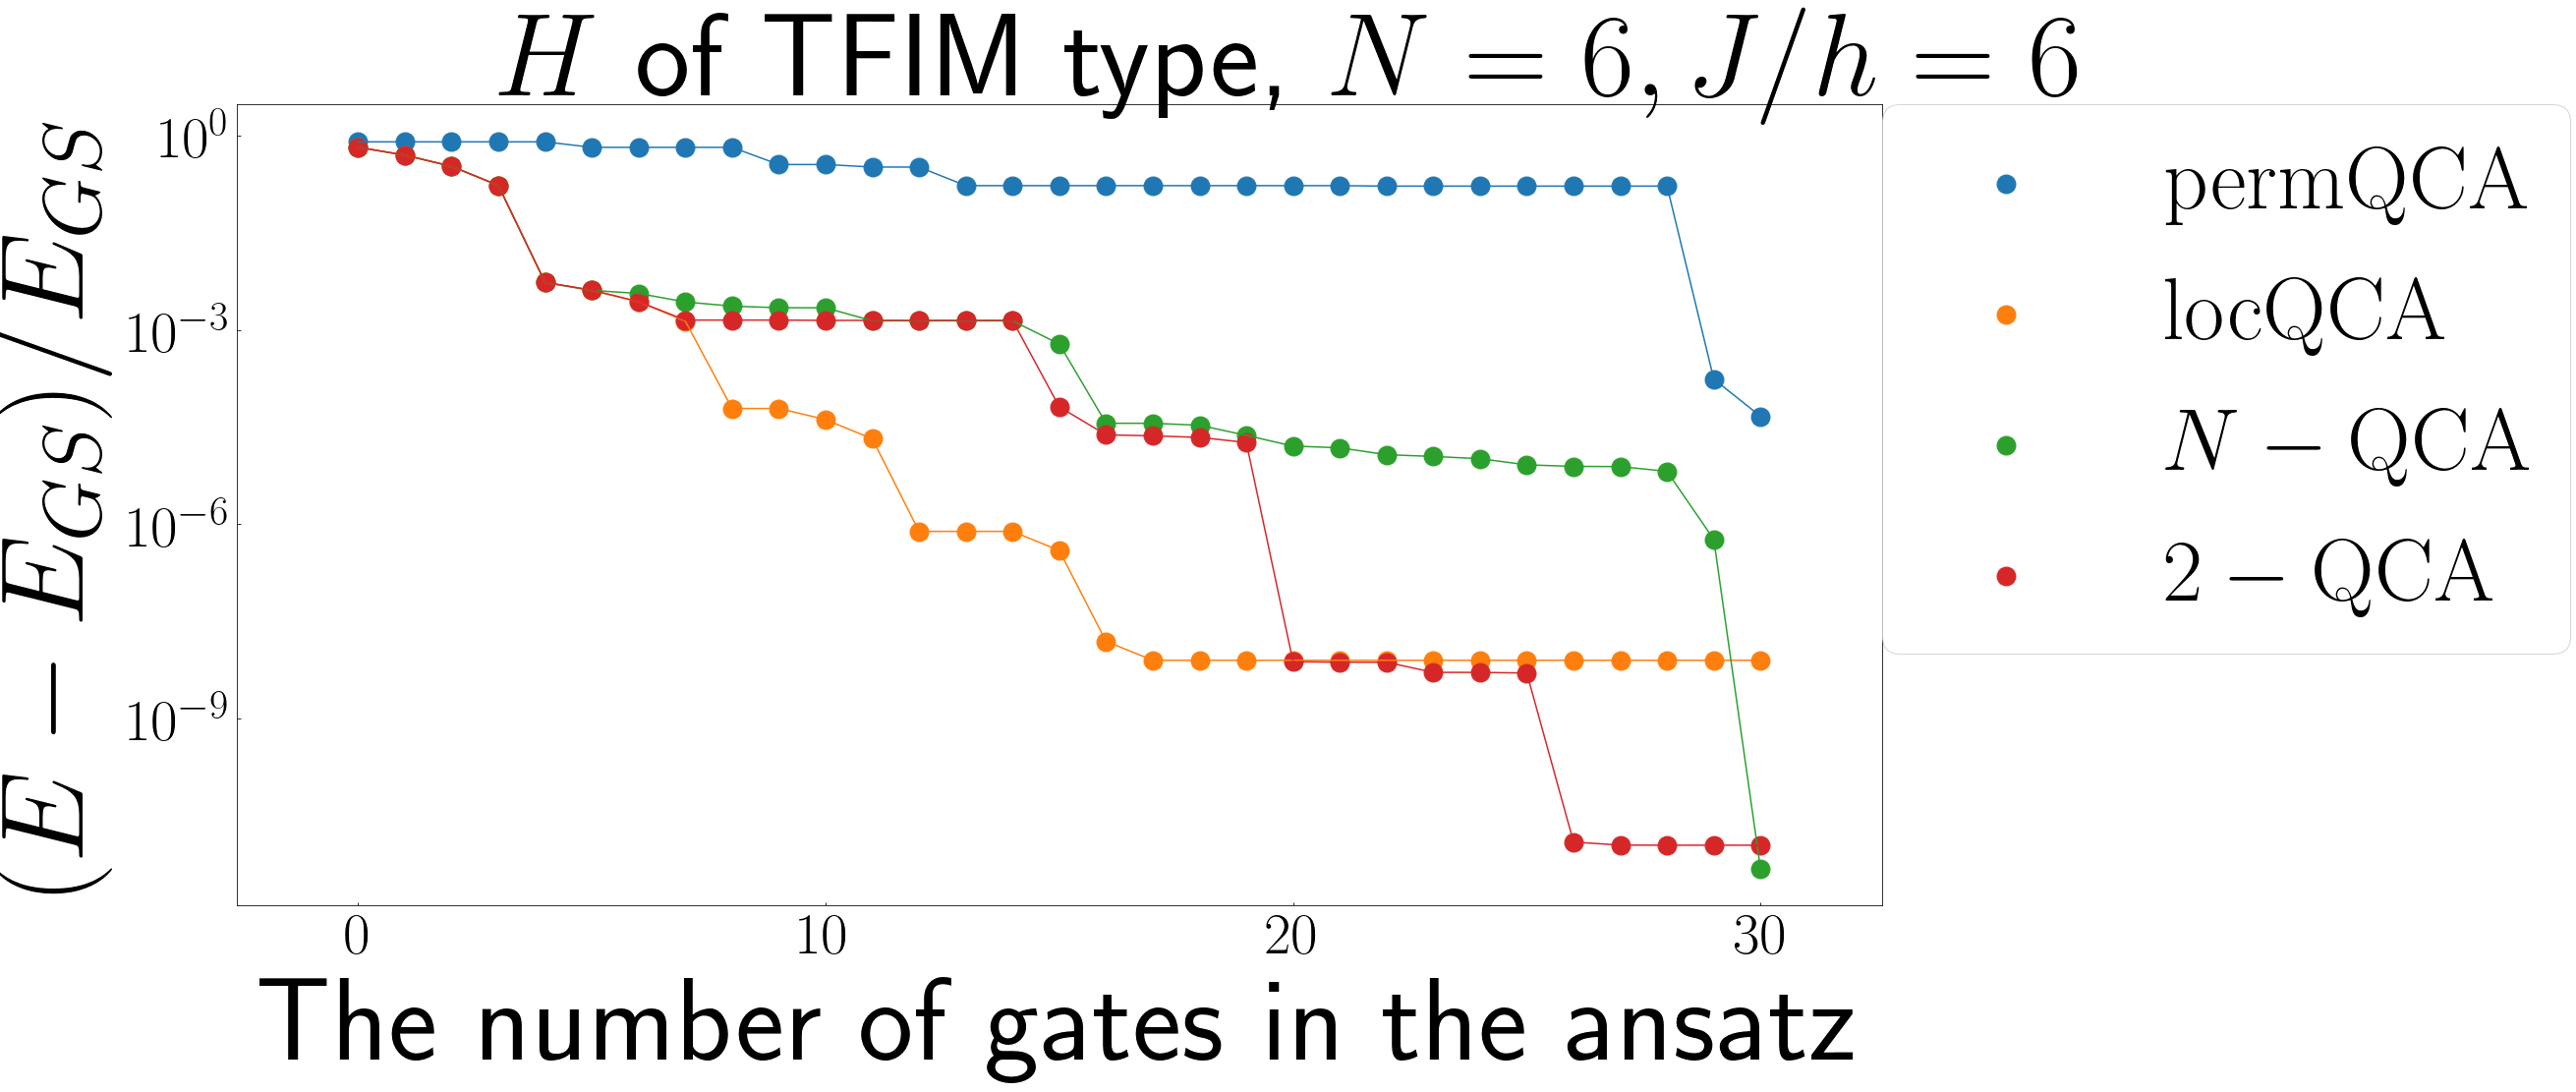

In [99]:
plt.rc('text', usetex=True)

# fig, ax = plt.subplots()

# ax.set_yscale('log')
scale=3
s=scale*120
plt.xlabel('The number of gates in the ansatz', fontsize=scale*40)
plt.ylabel('$(E-E_{GS})/E_{GS}$', fontsize=scale*40)
plt.plot(list(range(maxgates)),values(data_perm[0],1.005))
plt.scatter(list(range(maxgates)),values(data_perm[0],1.005),label="${\mathrm {permQCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_loc[0],1.005))
plt.scatter(list(range(maxgates)),values(data_loc[0],1.005),label="${\mathrm {locQCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_full_multordered[0],1.005))
plt.scatter(list(range(maxgates)),values(data_full_multordered[0],1.005),label="$N-{\mathrm {QCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_2loc[0],1.01))
plt.scatter(list(range(maxgates)),values(data_2loc[0],1.01),label="$2-{\mathrm {QCA}}$",s=s)
plt.text(3,1.5, '$H$ of TFIM type, $N=6, J/h=6$', {'color': 'black', 'fontsize': scale*40}, verticalalignment='bottom')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=scale*30)
plt.tick_params(direction='in')
# ax.set_xticklabels(1, rotation=0, fontsize=8)

plt.rcParams['xtick.labelsize']=scale*30
plt.rcParams['ytick.labelsize']=scale*30

fig=plt.gcf()
axes=plt.gca()
axes.set_yscale('log')
fig.set_size_inches(scale*10, scale*5)
print(fig)
#fig.savefig('TFIM_weak.png', bbox_inches='tight')
#fig.show()

/marisdata/herasymenko/.conda/envs/test/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


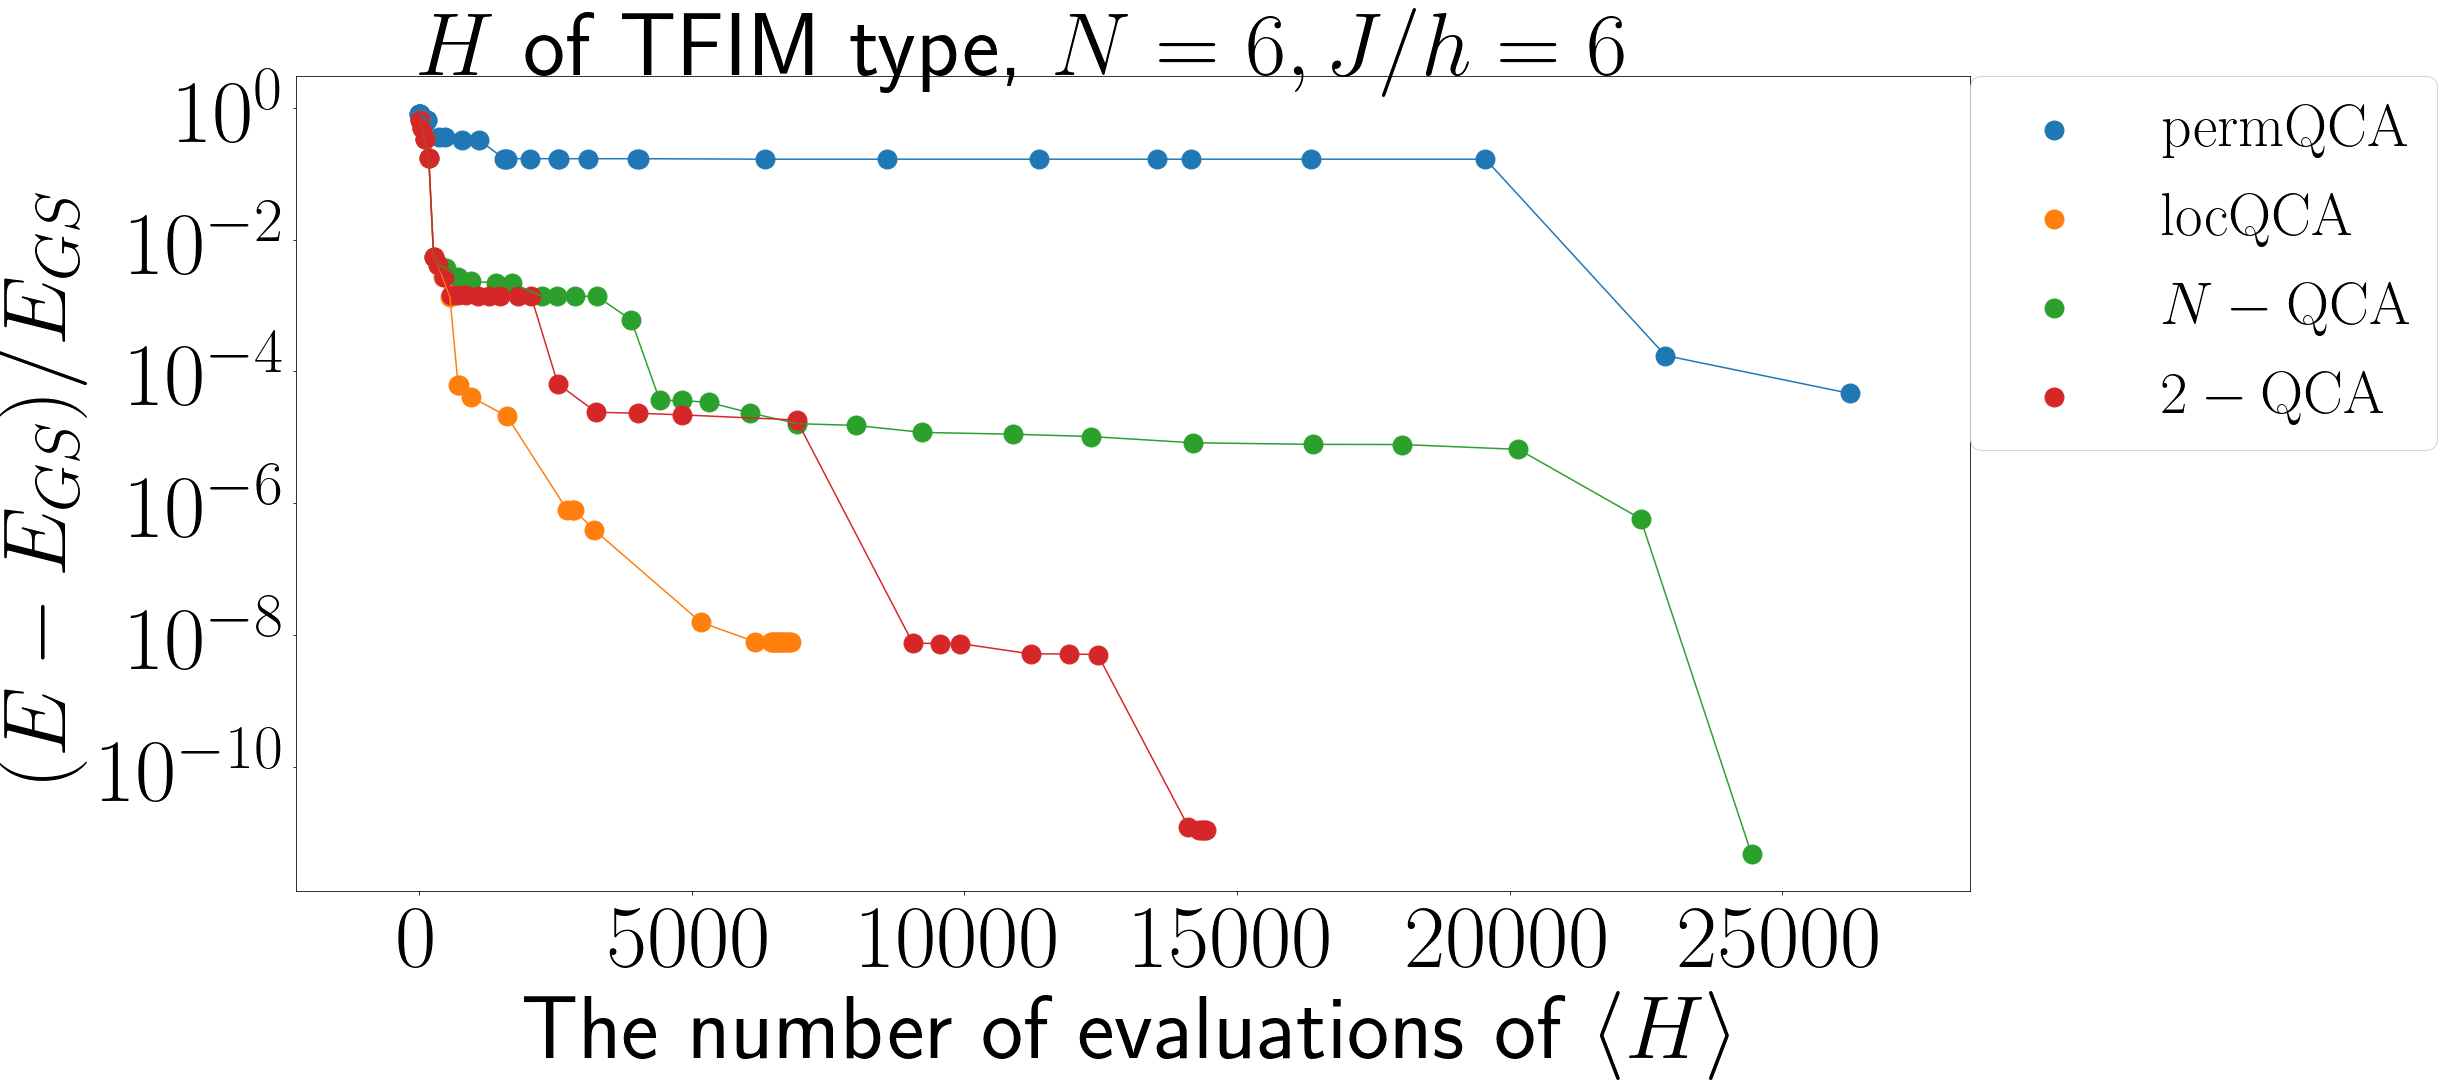

In [100]:
fig, ax = plt.subplots()



scale=3
s=scale*120
plt.xlabel('The number of evaluations of $\langle H \\rangle$', fontsize=scale*30)
plt.ylabel('$(E-E_{GS})/E_{GS}$', fontsize=scale*30)


plt.plot(total_measurements(data_perm[0]),values(data_perm[0],1.005))
plt.scatter(total_measurements(data_perm[0]),values(data_perm[0],1.005),label="${\mathrm {permQCA}}$",s=s)
plt.plot(total_measurements(data_loc[0]),values(data_loc[0],1.005))
plt.scatter(total_measurements(data_loc[0]),values(data_loc[0],1.005),label="${\mathrm {locQCA}}$",s=s)
plt.plot(total_measurements(data_full_multordered[0]),values(data_full_multordered[0],1.005))
plt.scatter(total_measurements(data_full_multordered[0]),values(data_full_multordered[0],1.005),label="$N-{\mathrm {QCA}}$",s=s)
plt.plot(total_measurements(data_2loc[0]),values(data_2loc[0],1.01))
plt.scatter(total_measurements(data_2loc[0]),values(data_2loc[0],1.01),label="$2-{\mathrm {QCA}}$",s=s)
plt.text(3,1.5, '$H$ of TFIM type, $N=6, J/h=6$', {'color': 'black', 'fontsize': scale*30}, verticalalignment='bottom')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=scale*20)

plt.rcParams['xtick.labelsize']=scale*20
plt.rcParams['ytick.labelsize']=scale*20

fig=plt.gcf()
# axes=plt.gca()
ax.set_yscale('log')
fig.set_size_inches(scale*10, scale*5)


fig.show()

Figure(2160x1080)


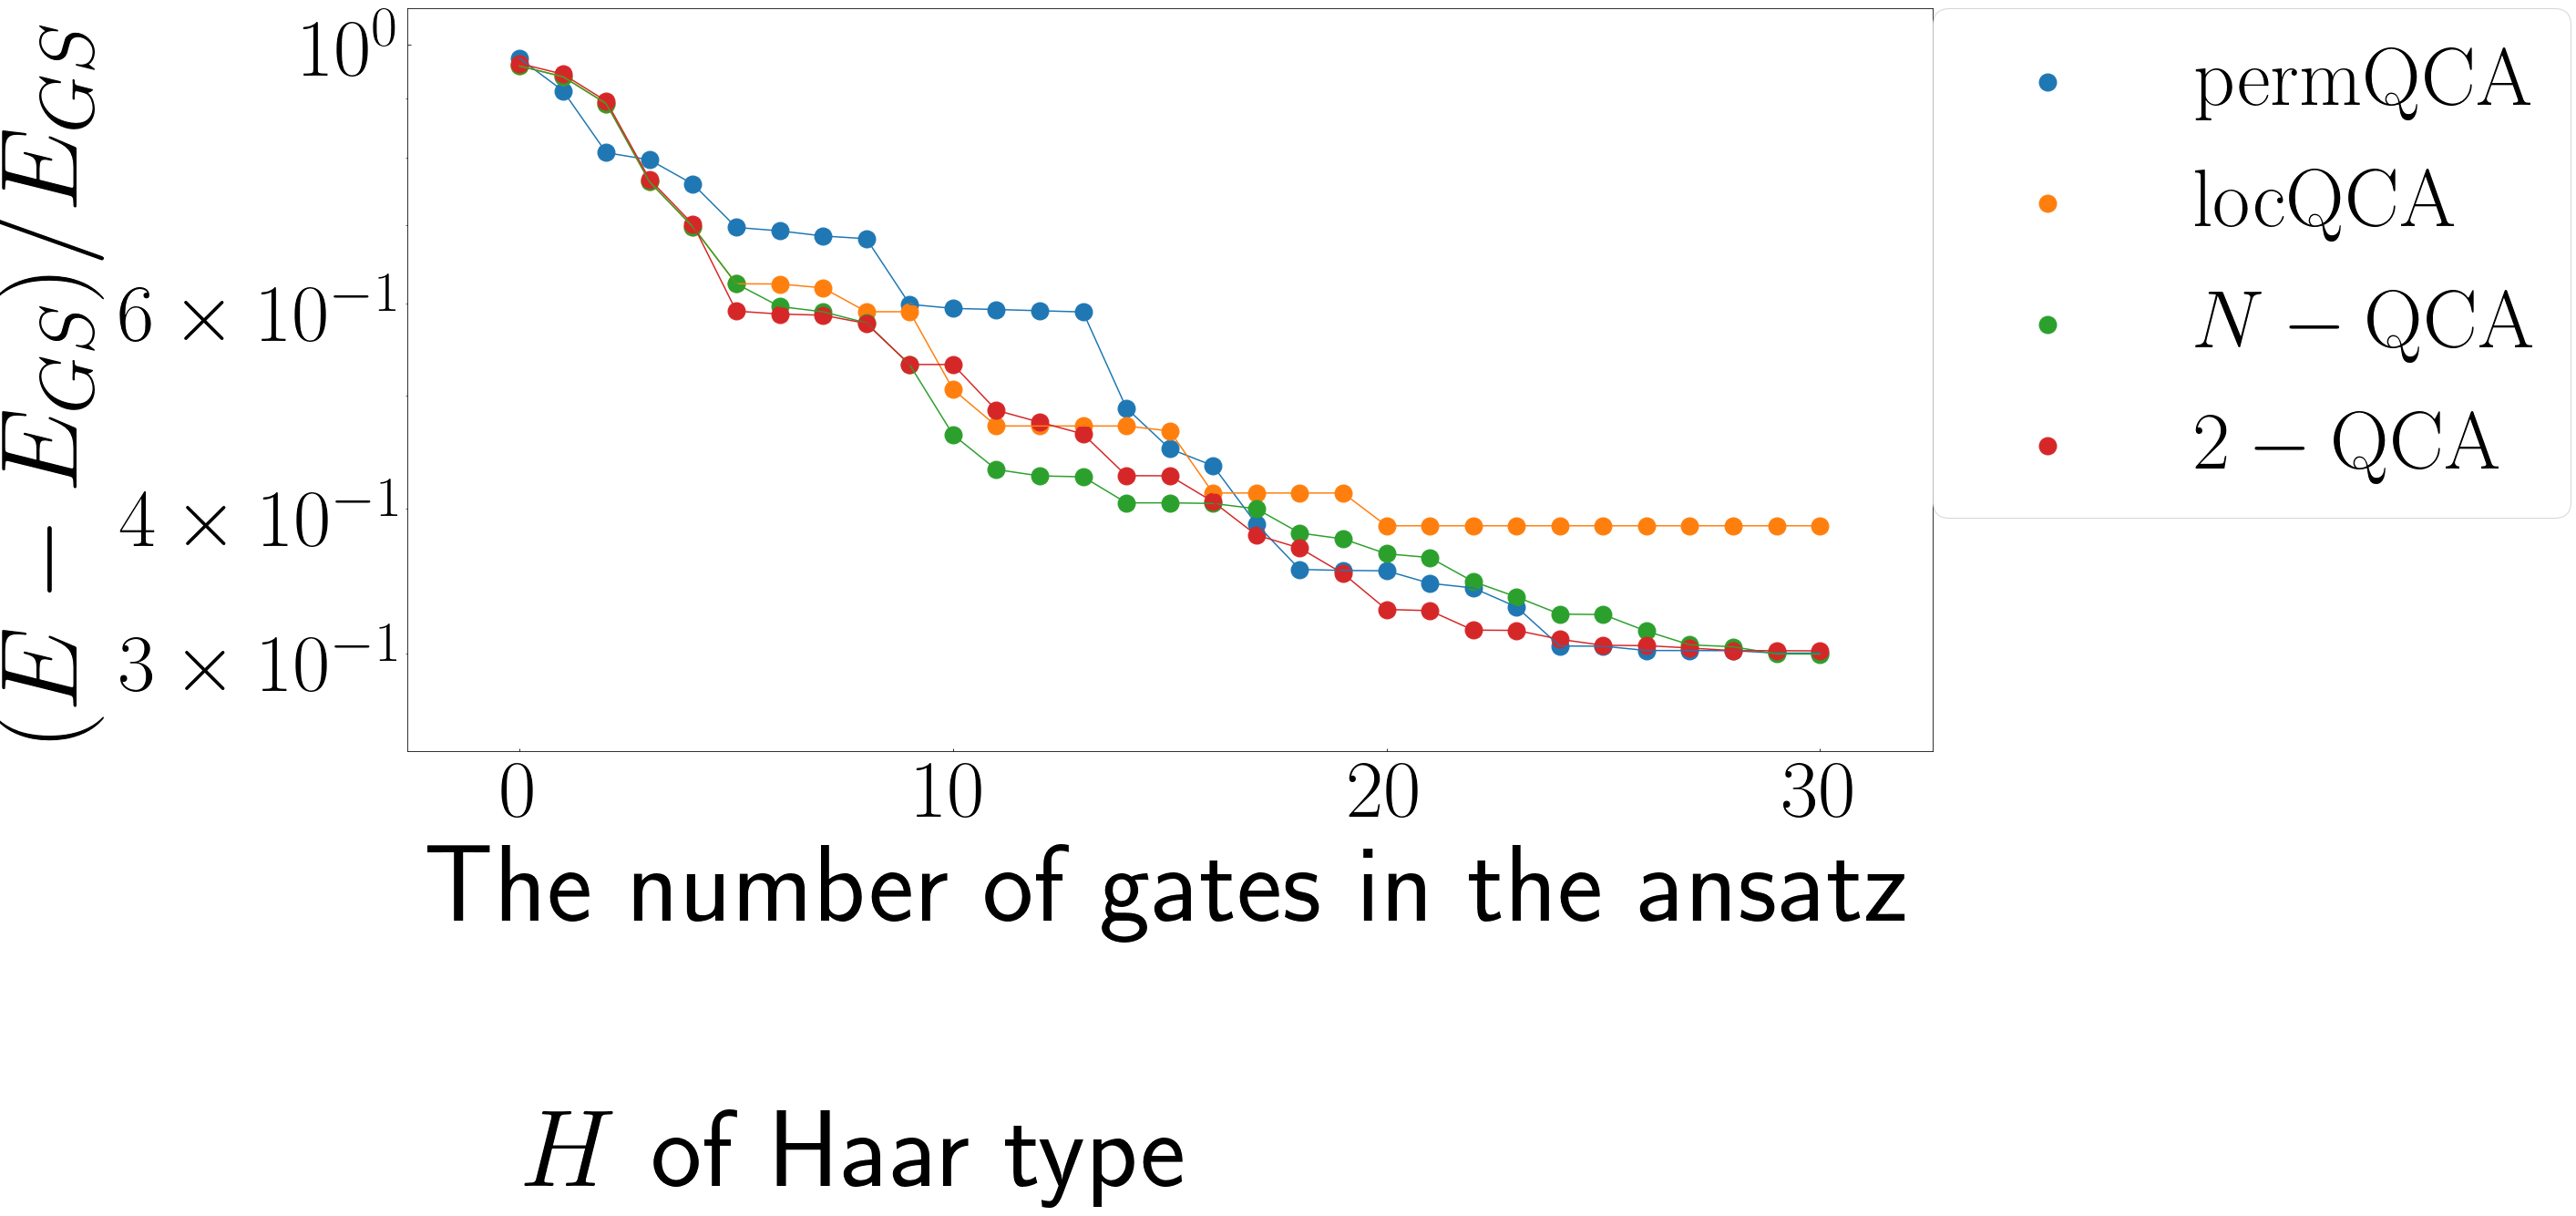

In [132]:
plt.rc('text', usetex=True)

# fig, ax = plt.subplots()

# ax.set_yscale('log')
scale=3
s=scale*120
plt.xlabel('The number of gates in the ansatz', fontsize=scale*40)
plt.ylabel('$(E-E_{GS})/E_{GS}$', fontsize=scale*40)
plt.plot(list(range(maxgates)),values(data_perm[0],1.005))
plt.scatter(list(range(maxgates)),values(data_perm[0],1.005),label="${\mathrm {permQCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_loc[0],1.005))
plt.scatter(list(range(maxgates)),values(data_loc[0],1.005),label="${\mathrm {locQCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_full_multordered[0],1.005))
plt.scatter(list(range(maxgates)),values(data_full_multordered[0],1.005),label="$N-{\mathrm {QCA}}$",s=s)
plt.plot(list(range(maxgates)),values(data_2loc[0],1.01))
plt.scatter(list(range(maxgates)),values(data_2loc[0],1.01),label="$2-{\mathrm {QCA}}$",s=s)
plt.text(0.1,0.1, '$H$ of Haar type', {'color': 'black', 'fontsize': scale*40}, verticalalignment='bottom')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=scale*30)
plt.tick_params(direction='in')
# ax.set_xticklabels(1, rotation=0, fontsize=8)

plt.rcParams['xtick.labelsize']=scale*30
plt.rcParams['ytick.labelsize']=scale*30

fig=plt.gcf()
axes=plt.gca()
axes.set_yscale('log')
fig.set_size_inches(scale*10, scale*5)
print(fig)
#fig.savefig('TFIM_weak.png', bbox_inches='tight')
#fig.show()

/marisdata/herasymenko/.conda/envs/test/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


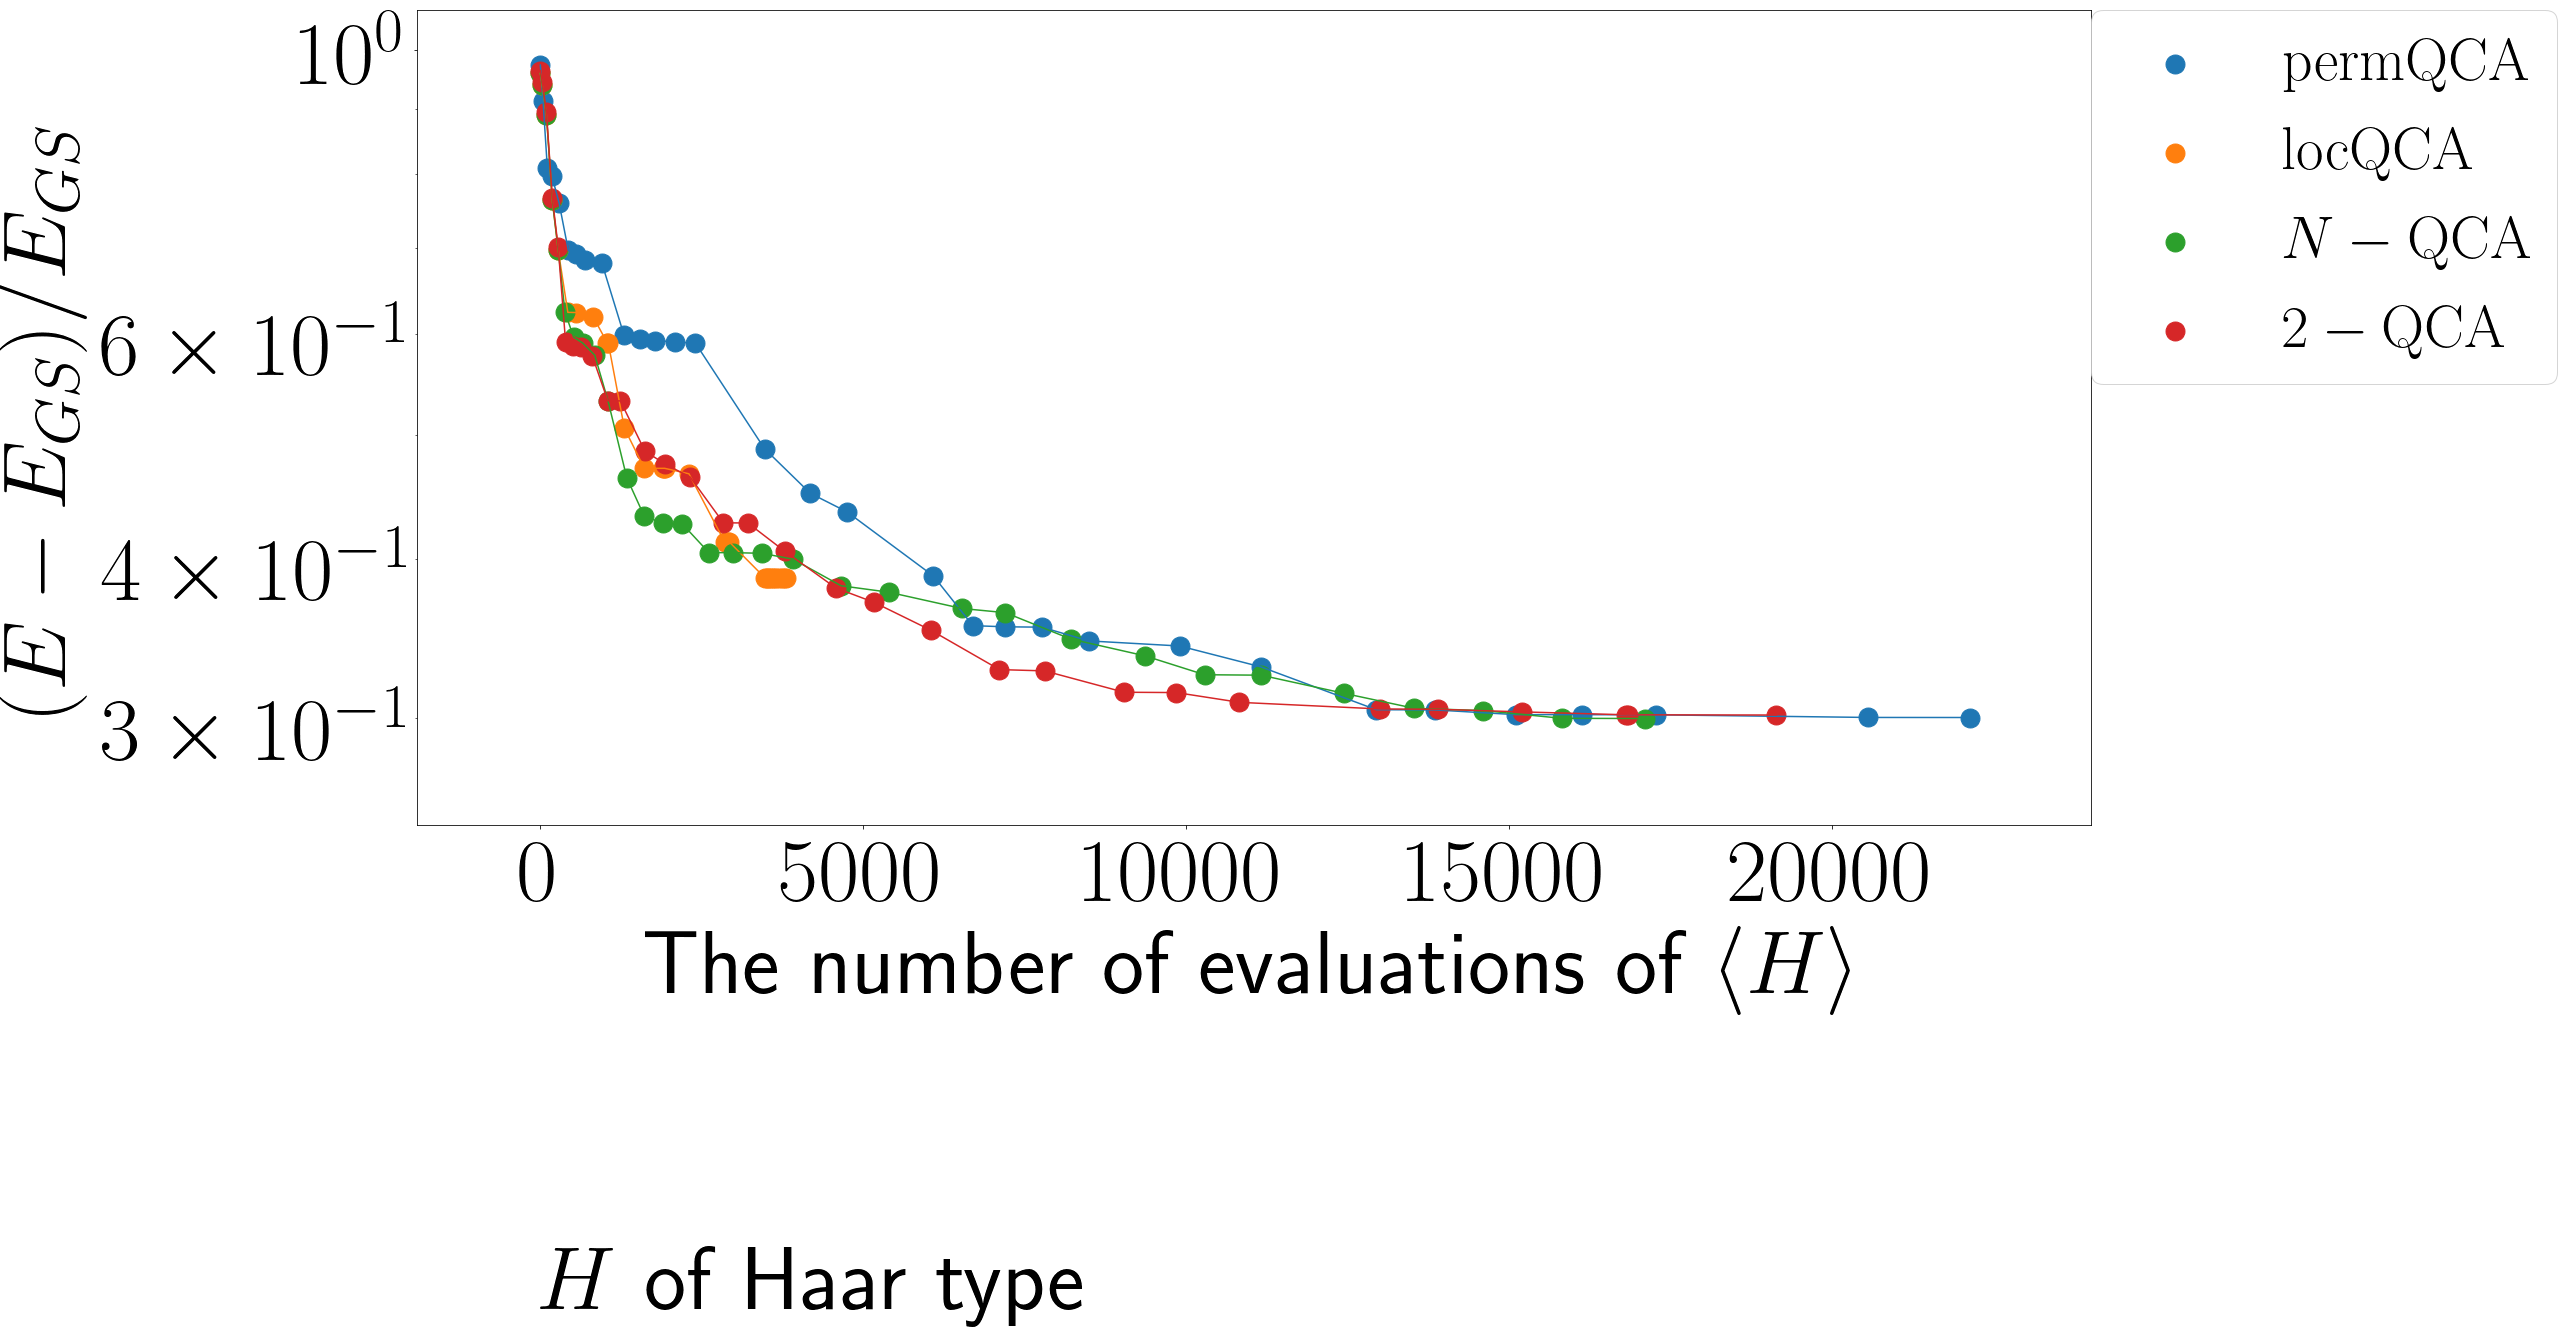

In [120]:
fig, ax = plt.subplots()



scale=3
s=scale*120
plt.xlabel('The number of evaluations of $\langle H \\rangle$', fontsize=scale*30)
plt.ylabel('$(E-E_{GS})/E_{GS}$', fontsize=scale*30)


plt.plot(total_measurements(data_perm[0]),values(data_perm[0],1.005))
plt.scatter(total_measurements(data_perm[0]),values(data_perm[0],1.005),label="${\mathrm {permQCA}}$",s=s)
plt.plot(total_measurements(data_loc[0]),values(data_loc[0],1.005))
plt.scatter(total_measurements(data_loc[0]),values(data_loc[0],1.005),label="${\mathrm {locQCA}}$",s=s)
plt.plot(total_measurements(data_full_multordered[0]),values(data_full_multordered[0],1.005))
plt.scatter(total_measurements(data_full_multordered[0]),values(data_full_multordered[0],1.005),label="$N-{\mathrm {QCA}}$",s=s)
plt.plot(total_measurements(data_2loc[0]),values(data_2loc[0],1.01))
plt.scatter(total_measurements(data_2loc[0]),values(data_2loc[0],1.01),label="$2-{\mathrm {QCA}}$",s=s)
plt.text(0.1,0.1, '$H$ of Haar type', {'color': 'black', 'fontsize': scale*30}, verticalalignment='bottom')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=scale*20)

plt.rcParams['xtick.labelsize']=scale*20
plt.rcParams['ytick.labelsize']=scale*20

fig=plt.gcf()
# axes=plt.gca()
ax.set_yscale('log')
fig.set_size_inches(scale*10, scale*5)


fig.show()